# [순환신경망 실습: 다변량 시계열 분류 모델링]

### 1. 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd

from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

import matplotlib.pyplot as plt


In [2]:
seed = 190731
np.random.seed(seed)
torch.cuda.set_device(0)

### 2. 데이터 불러오기: Torch 데이터 준비하기(다채널시그널데이터)

In [3]:
path = 'C:/Users/user/Desktop/한화시스템교육-딥러닝/2.실습자료-오전-조윤상/'

X_train, y_train = torch.load(path+'Data/classification_multivariate_train_x'), torch.load(path+'Data/classification_multivariate_train_y')
X_valid, y_valid = torch.load(path+'Data/classification_multivariate_valid_x'), torch.load(path+'Data/classification_multivariate_valid_y')


- 시그널 데이터 살펴보기

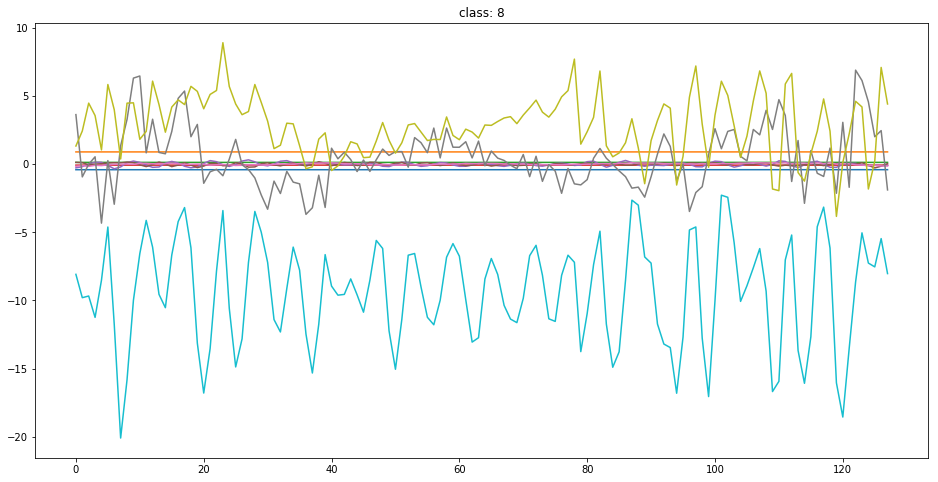

In [4]:
plt.figure(figsize=(16,8)) # 그래프 (가로길이, 세로길이)
plt.title('class: '+str(y_train[0].tolist()))
plt.plot(np.array(X_train[0,:,0])) # sensor 1
plt.plot(np.array(X_train[0,:,1])) # sensor 2
plt.plot(np.array(X_train[0,:,2])) # sensor 3
plt.plot(np.array(X_train[0,:,3])) # sensor 4
plt.plot(np.array(X_train[0,:,4])) # sensor 5
plt.plot(np.array(X_train[0,:,5])) # sensor 6
plt.plot(np.array(X_train[0,:,6])) # sensor 7
plt.plot(np.array(X_train[0,:,7])) # sensor 8
plt.plot(np.array(X_train[0,:,8])) # sensor 9
plt.plot(np.array(X_train[0,:,9])) # sensor 10
plt.show()

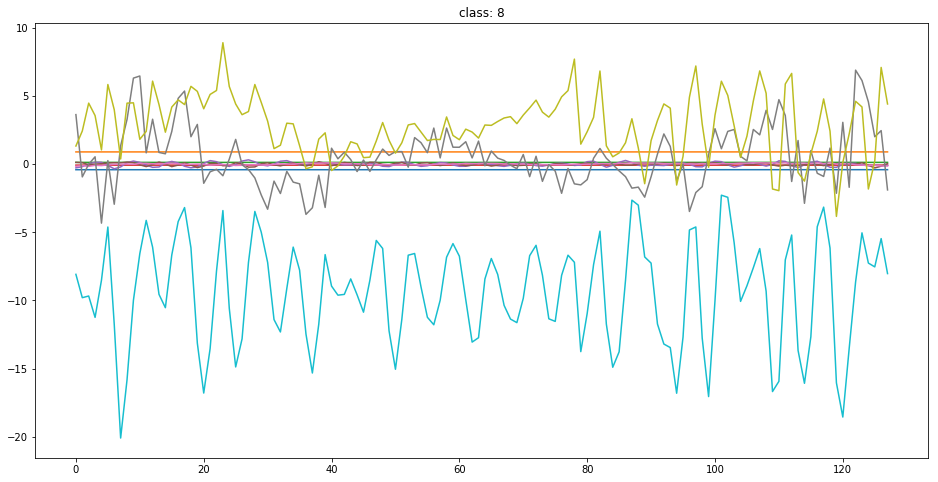

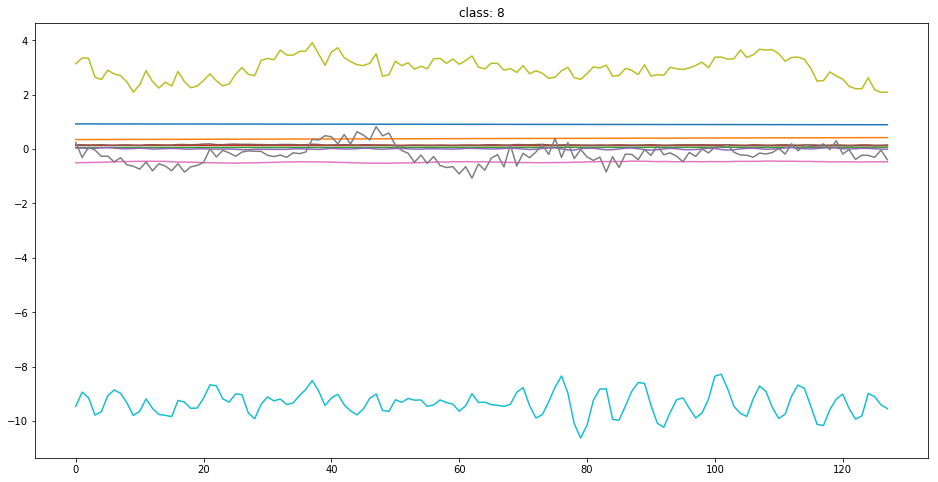

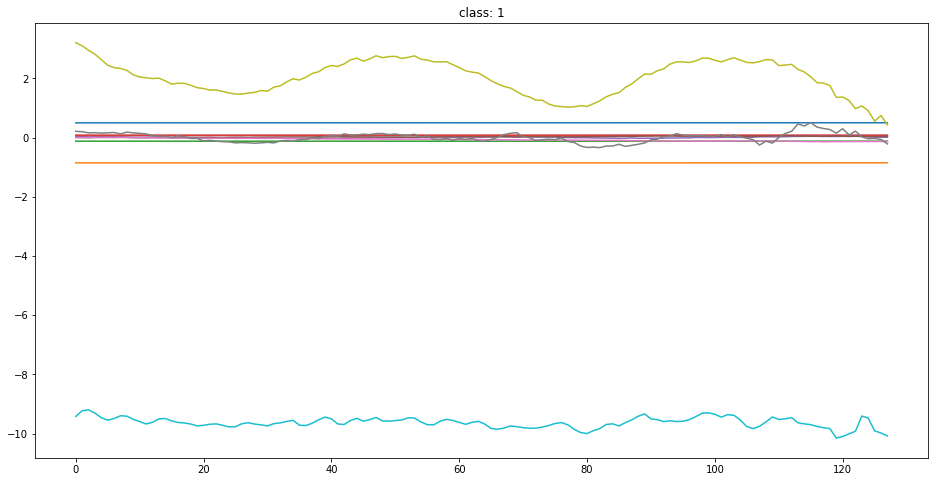

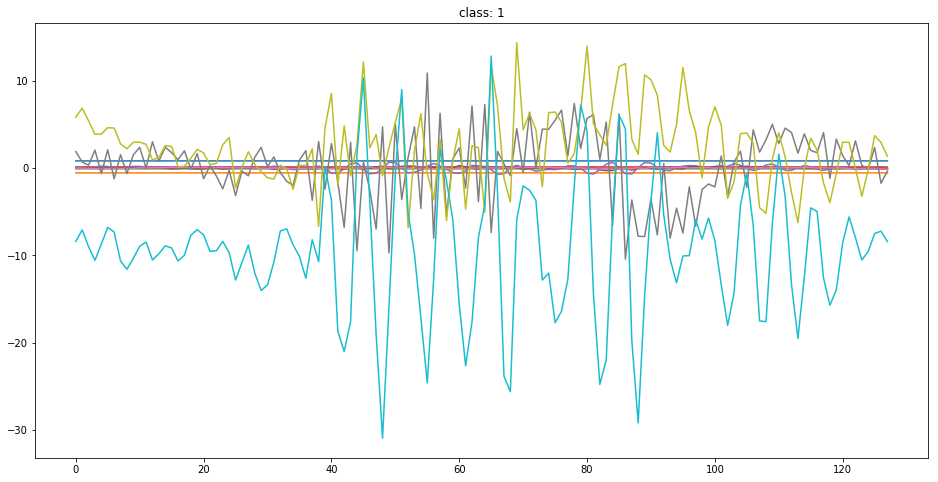

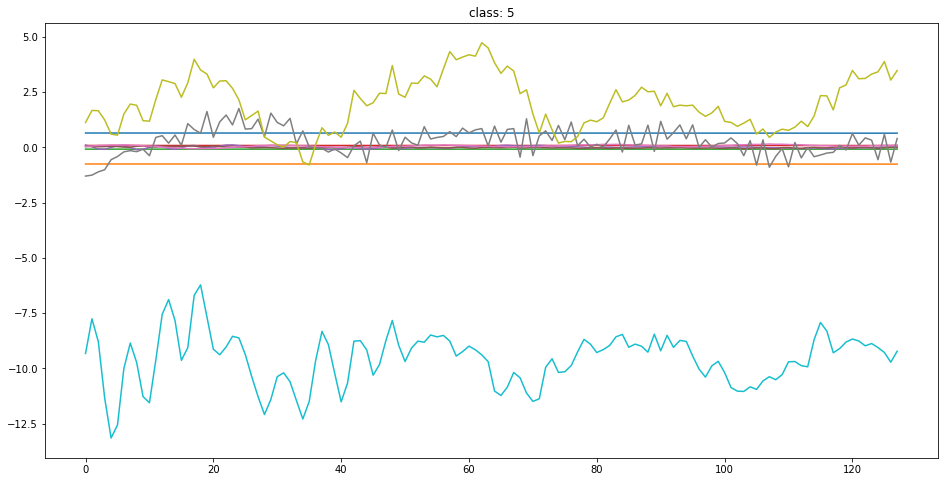

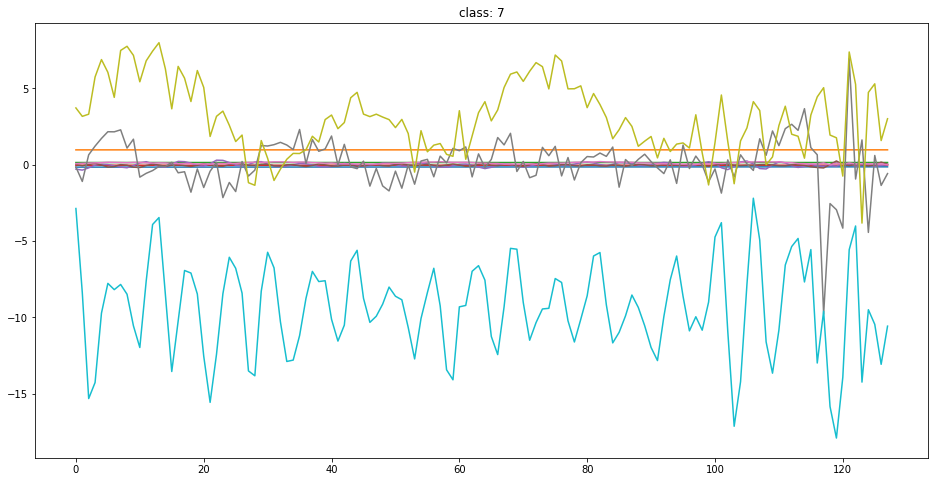

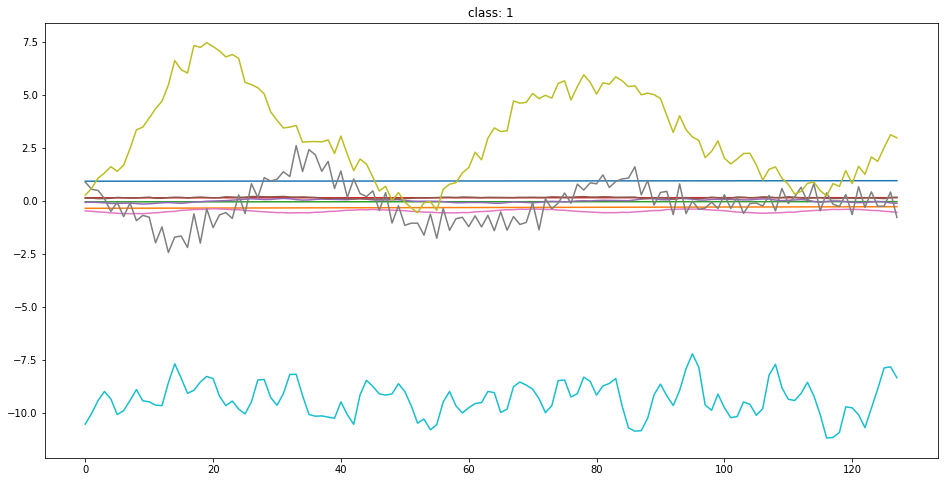

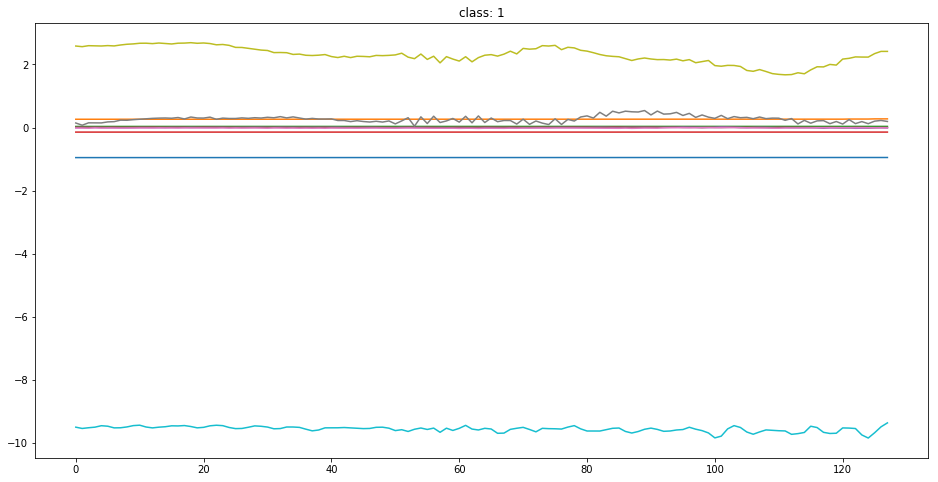

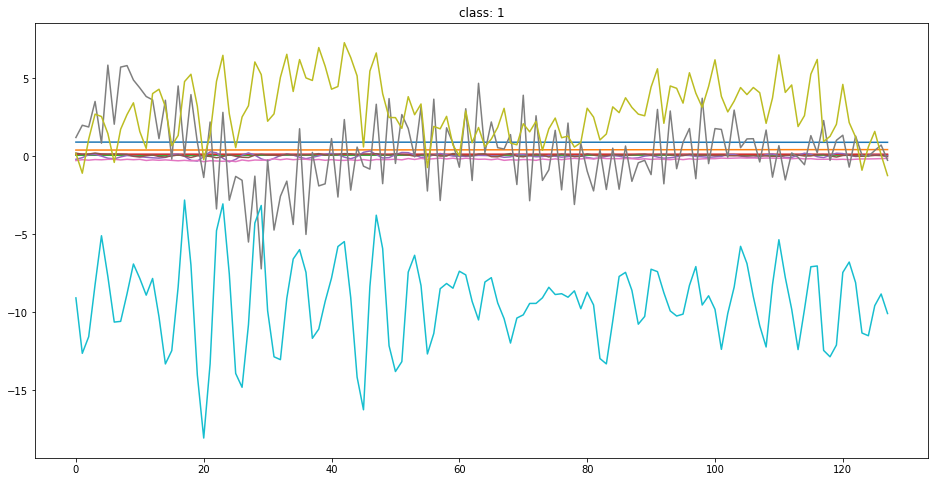

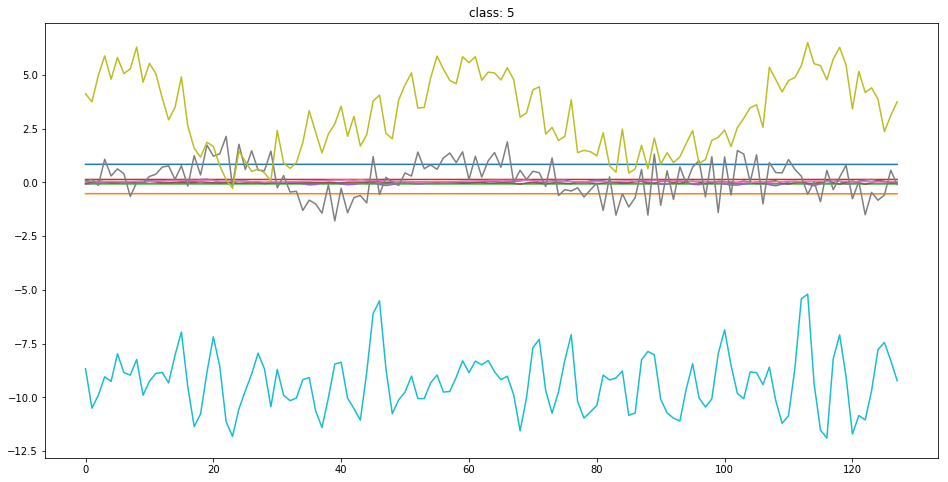

In [5]:
for i in range(0,10):
    plt.figure(figsize=(16,8)) # 그래프 (가로길이, 세로길이)
    plt.title('class: '+str(y_train[i].tolist()))
    plt.plot(np.array(X_train[i,:,0])) # sensor 1
    plt.plot(np.array(X_train[i,:,1])) # sensor 2
    plt.plot(np.array(X_train[i,:,2])) # sensor 3
    plt.plot(np.array(X_train[i,:,3])) # sensor 4
    plt.plot(np.array(X_train[i,:,4])) # sensor 5
    plt.plot(np.array(X_train[i,:,5])) # sensor 6
    plt.plot(np.array(X_train[i,:,6])) # sensor 7
    plt.plot(np.array(X_train[i,:,7])) # sensor 8
    plt.plot(np.array(X_train[i,:,8])) # sensor 9
    plt.plot(np.array(X_train[i,:,9])) # sensor 10
    plt.show()

### 3. 데이터 전처리: Batch iterator 생성하기
- data_utils의 TensorDataset과 DataLoader를 사용해 batch iterator 생성하기

In [6]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)   

In [7]:
batch_size = 128 # 사용자선택변수(hyperparameter)

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False)

print(f'Creating data loaders with batch size: {batch_size}')


Creating data loaders with batch size: 128


### 3. RNN 모델 생성하기

In [9]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [10]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128
lr = 0.0005
n_epochs = 100

In [11]:
#model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = RNNClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

In [12]:
print('Start model training')
for epoch in range(1, n_epochs + 1):
    # training part
    for i, (x_batch, y_batch) in enumerate(train_dl):
        model.train()       
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()        
        out = model(x_batch)        
        loss = criterion(out, y_batch)
        loss.backward()        
        optimizer.step()
    
    # evaluating part
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total
    
    print(f'Epoch: {epoch:3d}. 학습 Loss: {loss.item():.4f}. 평가정확도.: {acc:2.2%}')


Start model training
Epoch:   1. 학습 Loss: 2.0088. 평가정확도.: 23.10%
Epoch:   2. 학습 Loss: 1.8015. 평가정확도.: 29.40%
Epoch:   3. 학습 Loss: 1.9257. 평가정확도.: 22.31%
Epoch:   4. 학습 Loss: 1.9963. 평가정확도.: 19.42%
Epoch:   5. 학습 Loss: 2.0013. 평가정확도.: 15.75%
Epoch:   6. 학습 Loss: 2.0779. 평가정확도.: 22.83%
Epoch:   7. 학습 Loss: 1.8802. 평가정확도.: 24.67%
Epoch:   8. 학습 Loss: 1.6235. 평가정확도.: 30.71%
Epoch:   9. 학습 Loss: 1.6390. 평가정확도.: 35.70%
Epoch:  10. 학습 Loss: 1.6773. 평가정확도.: 36.75%
Epoch:  11. 학습 Loss: 1.7108. 평가정확도.: 37.01%
Epoch:  12. 학습 Loss: 1.5487. 평가정확도.: 37.01%
Epoch:  13. 학습 Loss: 1.4602. 평가정확도.: 37.27%
Epoch:  14. 학습 Loss: 1.6379. 평가정확도.: 38.06%
Epoch:  15. 학습 Loss: 1.4126. 평가정확도.: 40.68%
Epoch:  16. 학습 Loss: 1.5563. 평가정확도.: 40.42%
Epoch:  17. 학습 Loss: 1.4482. 평가정확도.: 37.53%
Epoch:  18. 학습 Loss: 1.4723. 평가정확도.: 44.36%
Epoch:  19. 학습 Loss: 1.4319. 평가정확도.: 43.31%
Epoch:  20. 학습 Loss: 1.2178. 평가정확도.: 44.36%
Epoch:  21. 학습 Loss: 1.3940. 평가정확도.: 45.41%
Epoch:  22. 학습 Loss: 1.4170. 평가정확도.: 45.14%
Epoch:  23.